# Bank Customer Segmentation and Recommendation System

## Step 1: Import Required Libraries

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')

## Step 2: Load and Explore the Dataset

In [4]:
# Load the dataset
df = pd.read_csv('german_credit_data.csv', index_col=0)

# Display first few rows
print(df.head())

# Check basic info
print("\nDataset Info:")
print(df.info())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Basic statistics
print("\nDescriptive Statistics:")
print(df.describe())

   Age     Sex  Job Housing Saving accounts Checking account  Credit amount  \
0   67    male    2     own             NaN           little           1169   
1   22  female    2     own          little         moderate           5951   
2   49    male    1     own          little              NaN           2096   
3   45    male    2    free          little           little           7882   
4   53    male    2    free          little           little           4870   

   Duration              Purpose  
0         6             radio/TV  
1        48             radio/TV  
2        12            education  
3        42  furniture/equipment  
4        24                  car  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job        

## Step 3: Data Preprocessing


Preprocessed Data:
        Age  Sex       Job  Housing  Saving accounts  Checking account  \
0  2.766456    1  0.146949        1                0                 0   
1 -1.191404    0  0.146949        1                0                 1   
2  1.183312    1 -1.383771        1                0                 0   
3  0.831502    1  0.146949        0                0                 0   
4  1.535122    1  0.146949        0                0                 0   

   Credit amount  Duration  Purpose  
0      -0.745131 -1.236478        5  
1       0.949817  2.248194        5  
2      -0.416562 -0.738668        3  
3       1.634247  1.750384        4  
4       0.566664  0.256953        1  


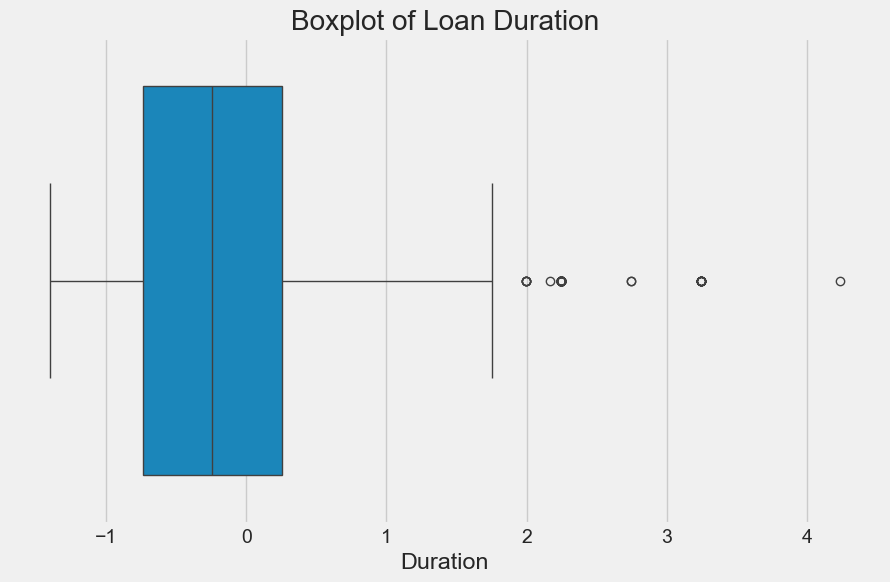

In [5]:

# Handle missing values
df['Saving accounts'].fillna(df['Saving accounts'].mode()[0], inplace=True)
df['Checking account'].fillna(df['Checking account'].mode()[0], inplace=True)

# Convert categorical variables to numerical
label_encoders = {}
categorical_cols = ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Create a copy of the original data before scaling
df_original = df.copy()

# Standardize numerical features
numerical_cols = ['Age', 'Job', 'Credit amount', 'Duration']
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

print("\nPreprocessed Data:")
print(df.head())

# Outlier Detection
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]


plt.figure(figsize=(10,6))
sns.boxplot(x=df['Duration'])
plt.title('Boxplot of Loan Duration')
plt.show()

## Step 4: Exploratory Data Analysis (EDA)

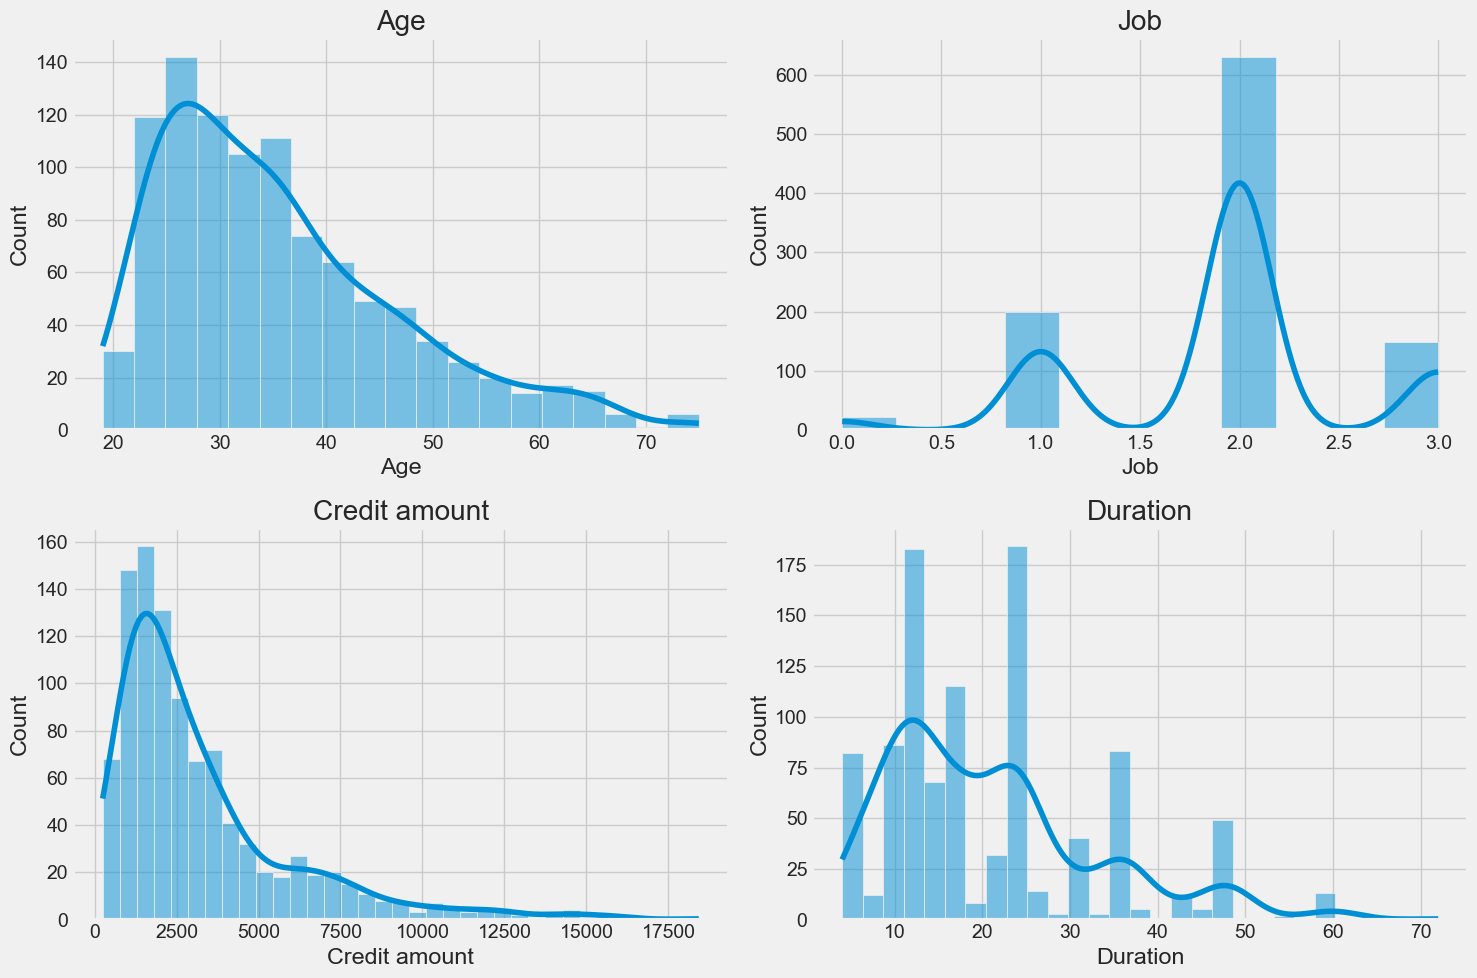

Plot categorical features 


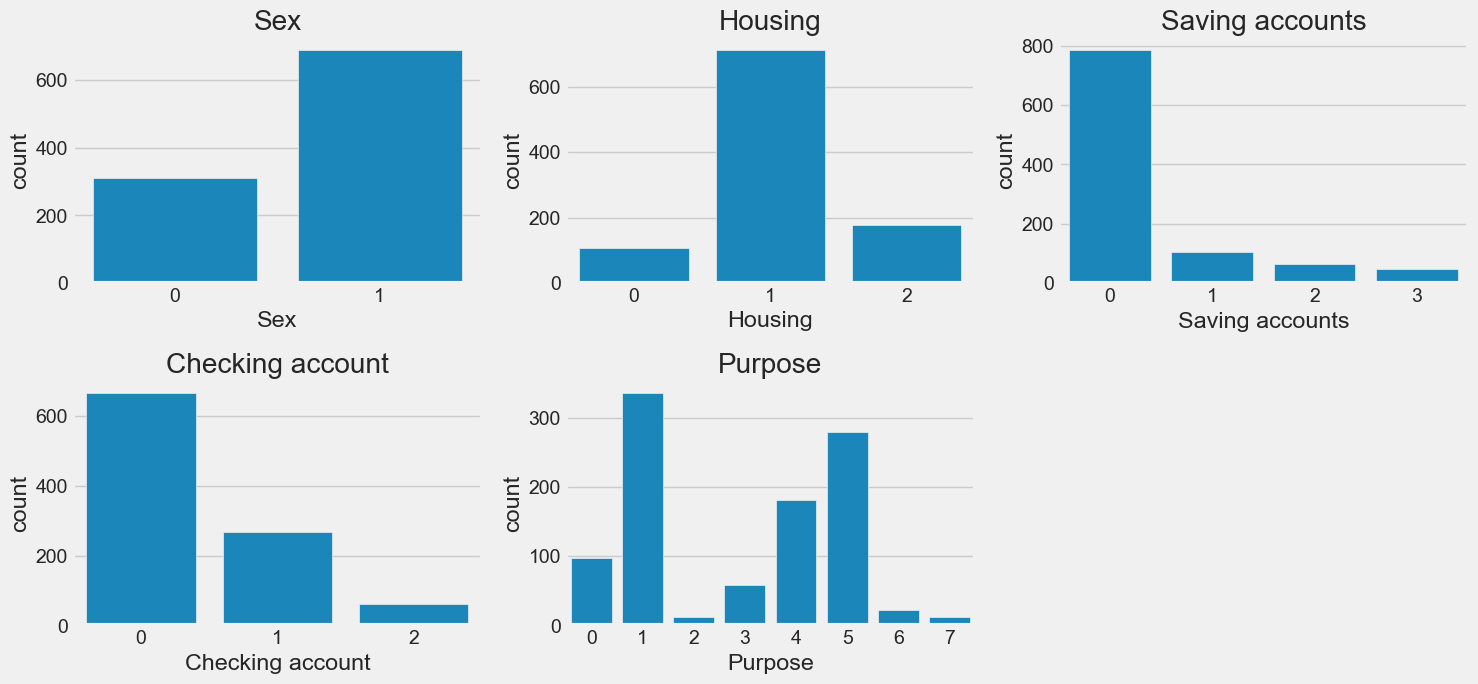

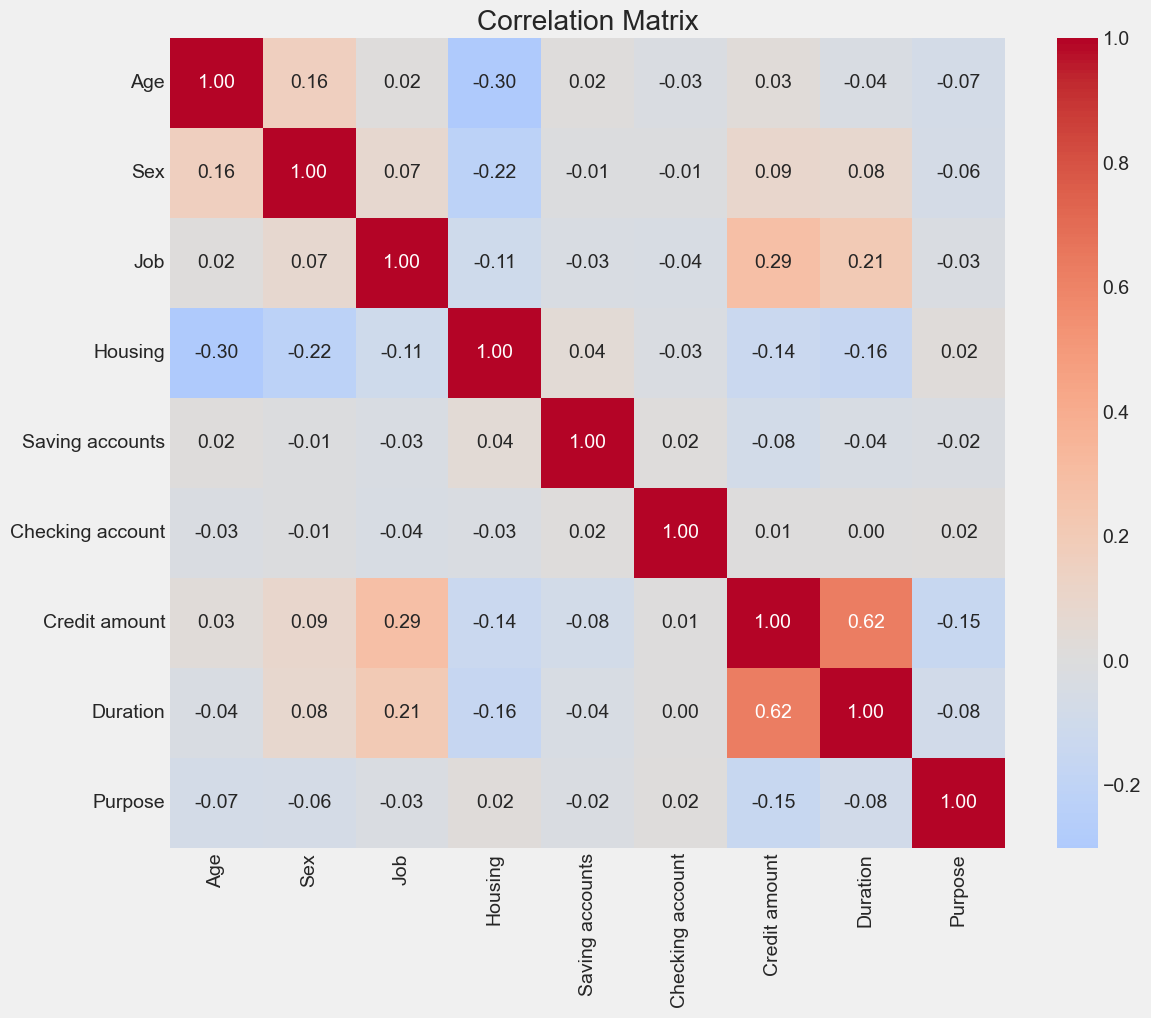

In [6]:
# Plot distributions of numerical features
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 2, i+1)  # 2 rows, 3 columns (total 6 positions)
    sns.histplot(df_original[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

# Plot categorical features
print("Plot categorical features ")
plt.figure(figsize=(15, 10))
for i, col in enumerate(categorical_cols):
    plt.subplot(3, 3, i+1)  # 2 rows, 2 columns (total 4 positions)
    sns.countplot(x=df_original[col])
    plt.title(col)
plt.tight_layout()
plt.show()

# Correlation matrix
plt.figure(figsize=(12, 10))  # Slightly larger for better readability
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

## Step 5: Determine Optimal Number of Clusters

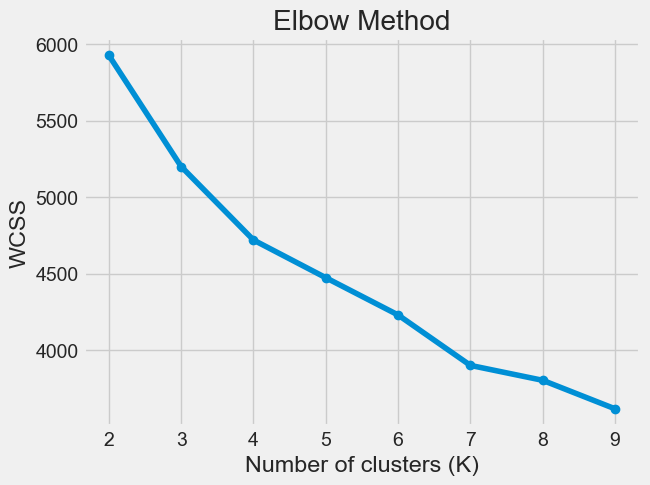

In [7]:
# Elbow method to find optimal number of clusters

wcss = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df)
    wcss.append(kmeans.inertia_)

# Plot elbow curve
plt.plot(range(2, 10), wcss, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

## Step 6: Perform K-Means Clustering


Cluster Summary:
               Age       Sex       Job   Housing  Saving accounts  \
Cluster                                                             
0        33.643478  0.739130  2.147826  0.930435         0.217391   
1        34.842466  0.632420  1.817352  1.134703         0.388128   
2        35.538462  0.695513  1.730769  1.125000         0.474359   
3        39.466667  0.822222  2.377778  0.859259         0.222222   

         Checking account  Credit amount   Duration   Purpose  
Cluster                                                        
0                0.426087    6059.921739  37.365217  4.652174  
1                0.397260    1987.598174  15.390411  4.518265  
2                0.381410    2218.833333  16.368590  0.849359  
3                0.392593    7492.762963  35.244444  0.733333  


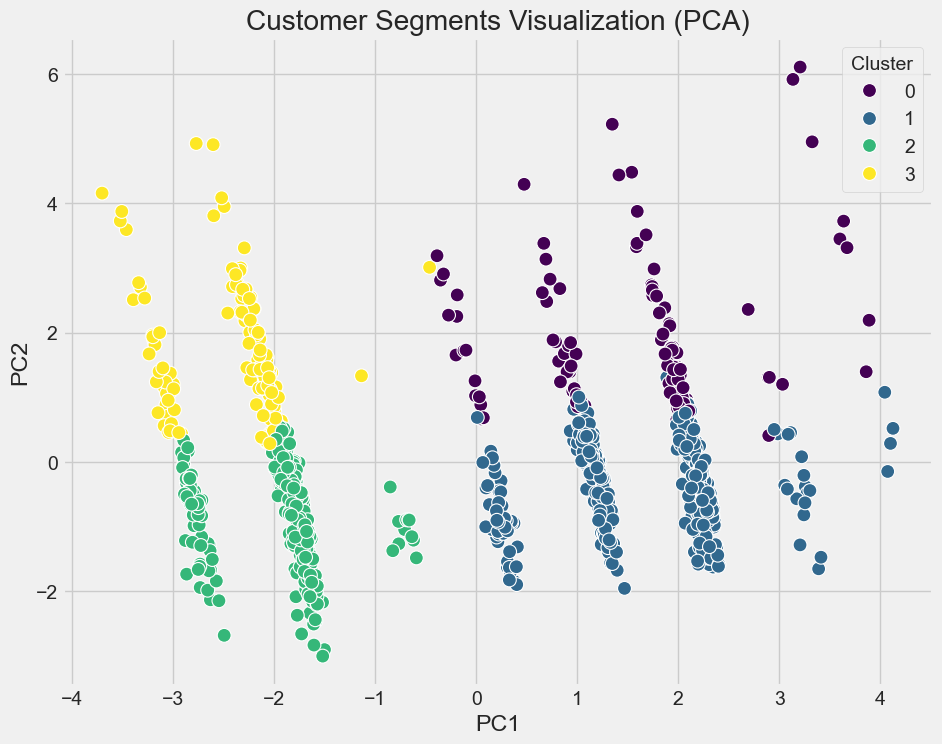

In [8]:
# Perform K-means clustering
optimal_k = 4  # choosed based on the elbow plots
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(df)

# Add cluster labels to the original dataframe
df_original['Cluster'] = clusters

# Analyze cluster characteristics
cluster_summary = df_original.groupby('Cluster').mean()
print("\nCluster Summary:")
print(cluster_summary)

# Visualize clusters using PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df)
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
principal_df['Cluster'] = clusters

plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=principal_df, palette='viridis', s=100)
plt.title('Customer Segments Visualization (PCA)')
plt.show()

## Step 7. Cluster Characteristics Visualization

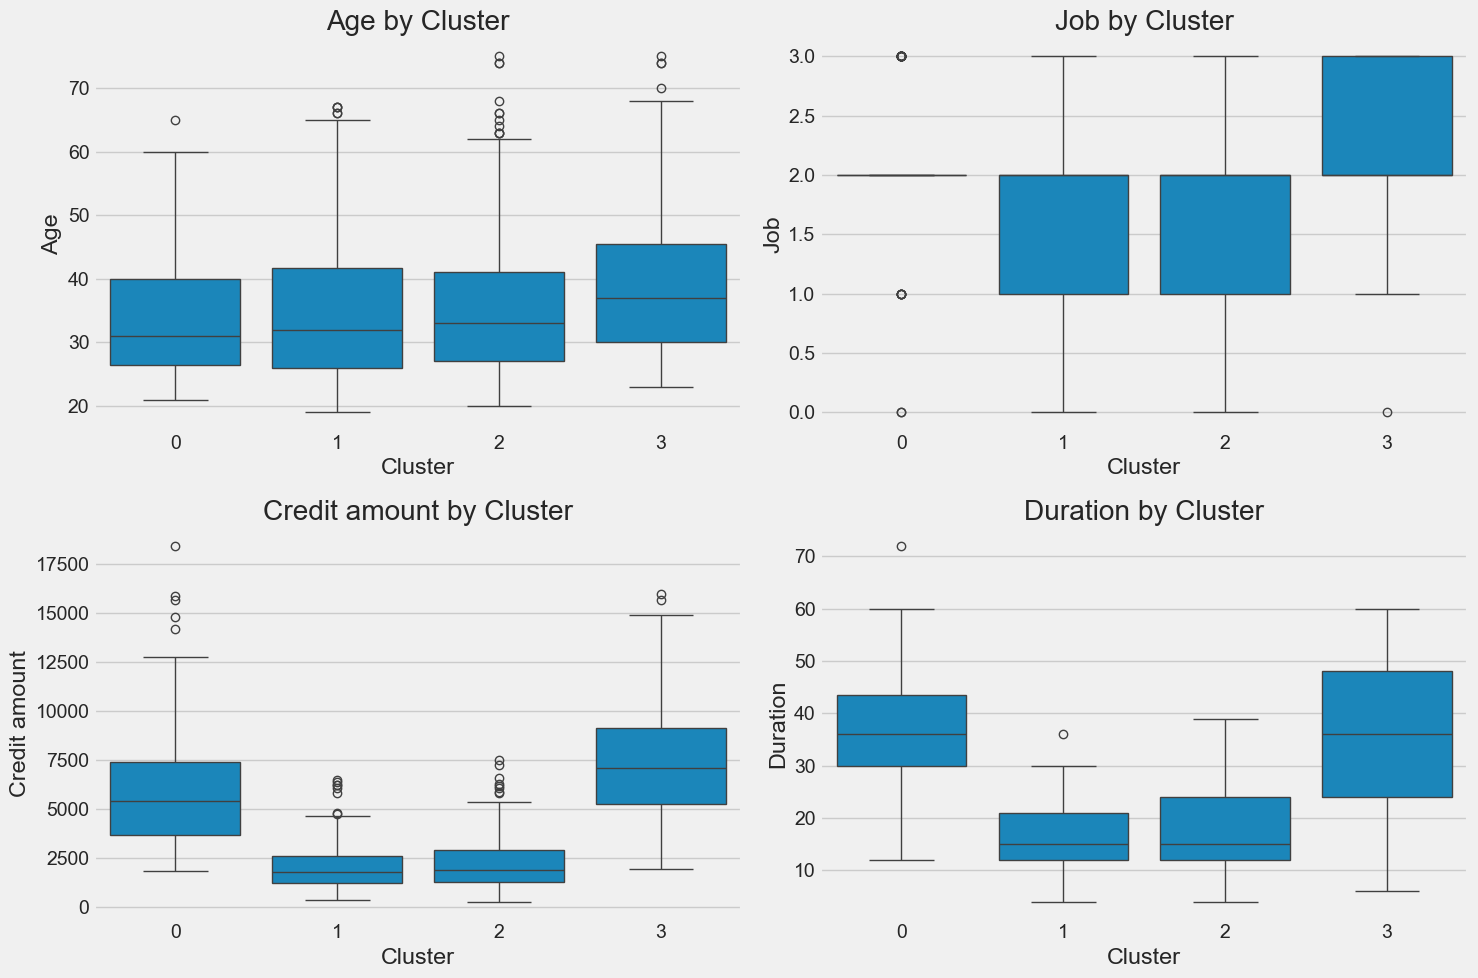

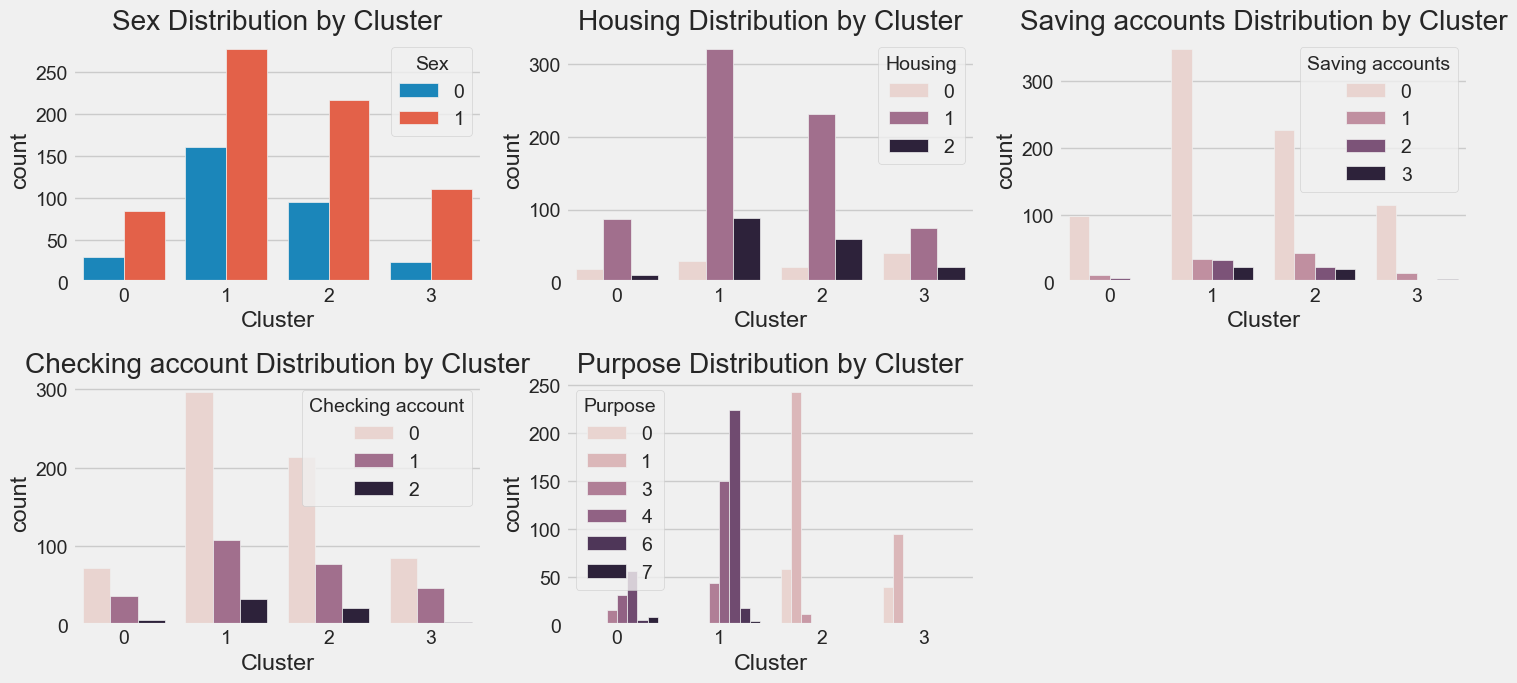

In [9]:
# Visualize cluster characteristics
plt.figure(figsize=(15, 10))

# Plot numerical features by cluster
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x='Cluster', y=col, data=df_original)
    plt.title(f'{col} by Cluster')

plt.tight_layout()
plt.show()

# Plot categorical features by cluster
plt.figure(figsize=(15, 10))
for i, col in enumerate(categorical_cols):
    plt.subplot(3, 3, i+1)
    sns.countplot(x='Cluster', hue=col, data=df_original)
    plt.title(f'{col} Distribution by Cluster')

plt.tight_layout()
plt.show()

## Step 8. Cluster Analysis and Interpretation
### Cluster Analysis

In [10]:
# Group by cluster and calculate mean of original (unscaled) values
cluster_original = df_original.groupby('Cluster')[['Age', 'Job', 'Credit amount', 'Duration']].mean()

# Add categorical features (mode)
cat_features = ['Sex', 'Housing', 'Saving accounts', 'Purpose']
for col in cat_features:
    cluster_original[col] = df_original.groupby('Cluster')[col].agg(lambda x: x.mode()[0])

# Decode categorical values
cluster_original['Sex'] = cluster_original['Sex'].map({1: 'Male', 0: 'Female'})
cluster_original['Housing'] = cluster_original['Housing'].map({0: 'own', 1: 'rent', 2: 'free'})
cluster_original['Saving accounts'] = cluster_original['Saving accounts'].map(
    {0: 'little', 1: 'moderate', 2: 'quite rich', 3: 'rich'})
cluster_original['Purpose'] = label_encoders['Purpose'].inverse_transform(cluster_original['Purpose'])

# Add cluster sizes
cluster_original['Customers (%)'] = df_original['Cluster'].value_counts(normalize=True).sort_index() * 100

print(cluster_original)

               Age       Job  Credit amount   Duration   Sex Housing  \
Cluster                                                                
0        33.643478  2.147826    6059.921739  37.365217  Male    rent   
1        34.842466  1.817352    1987.598174  15.390411  Male    rent   
2        35.538462  1.730769    2218.833333  16.368590  Male    rent   
3        39.466667  2.377778    7492.762963  35.244444  Male    rent   

        Saving accounts   Purpose  Customers (%)  
Cluster                                           
0                little  radio/TV           11.5  
1                little  radio/TV           43.8  
2                little       car           31.2  
3                little       car           13.5  


## Cluster Interpretations

In [12]:
# Function to interpret clusters
def interpret_clusters(cluster_summary, label_encoders):
    cluster_descriptions = {}
    
    for cluster in cluster_summary.index:
        description = []
        
        # Age
        age = cluster_summary.loc[cluster, 'Age']
        if age < 30:
            description.append("Young customers")
        elif age < 50:
            description.append("Middle-aged customers")
        else:
            description.append("Senior customers")
        
        # Job
        job = cluster_summary.loc[cluster, 'Job']
        if job < 1:
            description.append("Unskilled workers")
        elif job < 2:
            description.append("Skilled workers")
        else:
            description.append("Highly skilled professionals")
        
        # Credit amount
        credit = cluster_summary.loc[cluster, 'Credit amount']
        if credit < 2500:
            description.append("Low credit seekers")
        elif credit < 5000:
            description.append("Medium credit seekers")
        else:
            description.append("High credit seekers")
        
        # Purpose (decode using label encoder)
        purpose = cluster_summary.loc[cluster, 'Purpose']
        purpose_decoded = label_encoders['Purpose'].inverse_transform([int(round(purpose))])[0]
        description.append(f"Mainly seeking credit for {purpose_decoded}")
        
        cluster_descriptions[cluster] = ", ".join(description)
    
    return cluster_descriptions

# Interpret clusters
cluster_descriptions = interpret_clusters(cluster_summary, label_encoders)
print("\nCluster Descriptions:")
for cluster, desc in cluster_descriptions.items():
    print(f"Cluster {cluster}: {desc}")


Cluster Descriptions:
Cluster 0: Middle-aged customers, Highly skilled professionals, High credit seekers, Mainly seeking credit for radio/TV
Cluster 1: Middle-aged customers, Skilled workers, Low credit seekers, Mainly seeking credit for radio/TV
Cluster 2: Middle-aged customers, Skilled workers, Low credit seekers, Mainly seeking credit for car
Cluster 3: Middle-aged customers, Highly skilled professionals, High credit seekers, Mainly seeking credit for car


# Step 9. Generate business recommendations based on clusters


Business Recommendations by Cluster:

Cluster 0 (115 customers):
Characteristics: Middle-aged customers, Highly skilled professionals, High credit seekers, Mainly seeking credit for radio/TV
Recommended Actions:
  1. Focus on family-oriented financial products
  2. Offer home improvement loans if they own housing
  3. Promote investment and retirement planning services
  4. Offer premium banking services
  5. Provide wealth management advisory
  6. Promote high-limit credit cards with travel benefits
  7. Provide personalized loan officers for large credit needs

Cluster 1 (438 customers):
Characteristics: Middle-aged customers, Skilled workers, Low credit seekers, Mainly seeking credit for radio/TV
Recommended Actions:
  1. Focus on family-oriented financial products
  2. Offer home improvement loans if they own housing
  3. Promote credit cards with rewards programs
  4. Offer auto loans with competitive rates
  5. Offer small personal loans with quick approval

Cluster 2 (312 custo

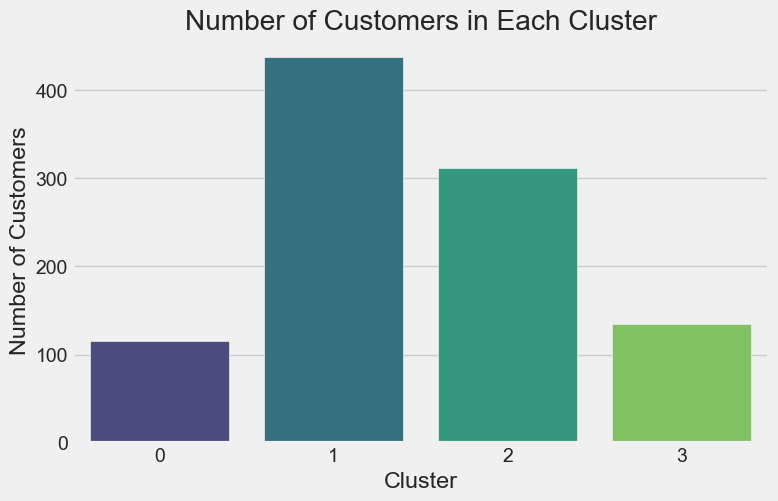

In [ ]:

def generate_business_recommendations(cluster_descriptions, cluster_summary):
    recommendations = {}
    
    for cluster, desc in cluster_descriptions.items():
        rec = []
        
        # Extract key characteristics from the description
        if "Young customers" in desc:
            rec.append("Target with digital banking solutions and mobile apps")
            rec.append("Offer educational content about financial planning")
            if "High credit seekers" in desc:
                rec.append("Consider offering student loan refinancing options")
        
        if "Middle-aged customers" in desc:
            rec.append("Focus on family-oriented financial products")
            rec.append("Offer home improvement loans if they own housing")
            if "High credit seekers" in desc:
                rec.append("Promote investment and retirement planning services")
        
        if "Senior customers" in desc:
            rec.append("Offer retirement planning services")
            rec.append("Provide simplified banking interfaces")
            rec.append("Consider lower-risk investment options")
        
        if "Unskilled workers" in desc:
            rec.append("Offer basic banking services with low fees")
            rec.append("Provide financial literacy programs")
        
        if "Skilled workers" in desc:
            rec.append("Promote credit cards with rewards programs")
            rec.append("Offer auto loans with competitive rates")
        
        if "Highly skilled professionals" in desc:
            rec.append("Offer premium banking services")
            rec.append("Provide wealth management advisory")
            rec.append("Promote high-limit credit cards with travel benefits")
        
        # Add recommendations based on credit amount
        avg_credit = cluster_summary.loc[cluster, 'Credit amount']
        if avg_credit < 2500:
            rec.append("Offer small personal loans with quick approval")
        elif avg_credit < 5000:
            rec.append("Promote medium-term installment loans")
        else:
            rec.append("Provide personalized loan officers for large credit needs")
        
        # Add recommendations based on purpose
        if "car" in desc.lower():
            rec.append("Partner with local car dealerships for financing options")
            rec.append("Offer competitive auto loan rates")
        
        if "furniture" in desc.lower() or "domestic appliances" in desc.lower():
            rec.append("Create partnerships with furniture/appliance stores")
            rec.append("Offer special financing for home goods purchases")
        
        if "education" in desc.lower():
            rec.append("Promote student loan products")
            rec.append("Offer education savings accounts")
        
        if "business" in desc.lower():
            rec.append("Offer small business banking services")
            rec.append("Provide business credit lines")
        
        recommendations[cluster] = {
            'description': desc,
            'recommendations': rec,
            'size': len(df_original[df_original['Cluster'] == cluster])
        }
    
    return recommendations

# Generate and display business recommendations
business_recommendations = generate_business_recommendations(cluster_descriptions, cluster_summary)

print("\nBusiness Recommendations by Cluster:")
for cluster, data in business_recommendations.items():
    print(f"\nCluster {cluster} ({data['size']} customers):")
    print(f"Characteristics: {data['description']}")
    print("Recommended Actions:")
    for i, recommendation in enumerate(data['recommendations'], 1):
        print(f"  {i}. {recommendation}")

# Visualize cluster sizes
plt.figure(figsize=(8, 5))
cluster_sizes = df_original['Cluster'].value_counts()
sns.barplot(x=cluster_sizes.index, y=cluster_sizes.values, palette='viridis')
plt.title('Number of Customers in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.show()


# Save the Recommendation Report to file

In [38]:
# Generate business recommendations
business_recommendations = generate_business_recommendations(cluster_descriptions, cluster_summary)

# Save to a text file
with open('business_recommendations.txt', 'w') as f:
    f.write("Business Recommendations by Cluster:\n\n")
    for cluster, data in business_recommendations.items():
        f.write(f"Cluster {cluster} ({data['size']} customers):\n")
        f.write(f"Characteristics: {data['description']}\n")
        f.write("Recommended Actions:\n")
        for i, recommendation in enumerate(data['recommendations'], 1):
            f.write(f"  {i}. {recommendation}\n")
        f.write("\n")  # Add extra space between clusters

print("Recommendations saved to 'business_recommendations.txt'")

Recommendations saved to 'business_recommendations.txt'


# Dashboard

In [21]:
import plotly.express as px
import plotly.subplots as sp
from plotly import graph_objects as go

# 1. Cluster Distribution Pie Chart
cluster_dist = df_original['Cluster'].value_counts().reset_index()
fig1 = px.pie(cluster_dist, values='count', names='Cluster', 
             title='Customer Cluster Distribution',
             color='Cluster', color_discrete_sequence=px.colors.qualitative.Pastel)

# 2. Key Metrics by Cluster
metrics = df_original.groupby('Cluster').agg({
    'Age': 'mean',
    'Credit amount': 'mean',
    'Duration': 'mean'
}).reset_index()

fig2 = sp.make_subplots(rows=1, cols=3, subplot_titles=('Avg Age', 'Avg Loan Amount (€)', 'Avg Duration (Months)'))

fig2.add_trace(go.Bar(x=metrics['Cluster'], y=metrics['Age'], name='Age'), row=1, col=1)
fig2.add_trace(go.Bar(x=metrics['Cluster'], y=metrics['Credit amount'], name='Loan Amount'), row=1, col=2)
fig2.add_trace(go.Bar(x=metrics['Cluster'], y=metrics['Duration'], name='Duration'), row=1, col=3)
fig2.update_layout(title_text='Key Metrics by Cluster', showlegend=False)

# 3. Strategic Recommendations Table
recommendations = {
    'Cluster': [0, 1, 2, 3],
    'Profile': ['Young Entrepreneurs', 'Car Buyers', 'Home Improvers', 'Property Investors'],
    'Product': ['Business Loans', 'Auto Loans', 'Retail Financing', 'Mortgages'],
    'Action': [
        'Digital ads + mentorship',
        'Dealer partnerships',
        'In-store promotions',
        'Personal relationship managers'
    ]
}

fig3 = go.Figure(data=[go.Table(
    header=dict(values=list(recommendations.keys())),
    cells=dict(values=list(recommendations.values()))
)])
fig3.update_layout(title='Strategic Recommendations by Cluster')

# 4. Purpose Breakdown
fig4 = px.sunburst(df_original, path=['Cluster', 'Purpose'], 
                  title='Loan Purpose Distribution by Cluster')

# Combine all figures into dashboard
dashboard = sp.make_subplots(
    rows=2, cols=2,
    specs=[[{"type": "pie"}, {"type": "bar"}],
           [{"type": "table"}, {"type": "sunburst"}]],
    subplot_titles=(
        "Customer Segmentation",
        "Key Cluster Metrics",
        "Action Plan",
        "Purpose Analysis"
    ))

# Add individual plots to dashboard
dashboard.add_trace(fig1.data[0], row=1, col=1)
for trace in fig2.data:
    dashboard.add_trace(trace, row=1, col=2)
dashboard.add_trace(fig3.data[0], row=2, col=1)
dashboard.add_trace(fig4.data[0], row=2, col=2)

dashboard.update_layout(height=1000, width=1200, title_text="Bank Customer Segmentation Dashboard", showlegend=False)
dashboard.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [22]:
marketing_strategy = {
    'Cluster 0': {
        'Channel': 'LinkedIn + Business Podcasts',
        'Message': "Grow your business with tailored loans",
        'Offer': "Free 6-month accounting software"
    },
    'Cluster 1': {
        'Channel': 'YouTube + Auto Websites',
        'Message': "Low-interest car loans approved in 1 hour",
        'Offer': "Free 1st year insurance"
    },
    'Cluster 2': {
        'Channel': 'Facebook/Instagram',
        'Message': "Buy now, pay later for your dream home",
        'Offer': "0% EMI for 6 months"
    },
    'Cluster 3': {
        'Channel': 'Personal Meetings',
        'Message': "Exclusive property investment opportunities",
        'Offer': "Wealth management consultation"
    }
}

print("Marketing Strategy by Cluster:")
pd.DataFrame(marketing_strategy).T

Marketing Strategy by Cluster:


,Channel,Message,Offer
Cluster 0,LinkedIn + Business Podcasts,Grow your business with tailored loans,Free 6-month accounting software
Cluster 1,YouTube + Auto Websites,Low-interest car loans approved in 1 hour,Free 1st year insurance
Cluster 2,Facebook/Instagram,"Buy now, pay later for your dream home",0% EMI for 6 months
Cluster 3,Personal Meetings,Exclusive property investment opportunities,Wealth management consultation


In [15]:
# Generate a comprehensive segmentation report
def generate_segmentation_report(business_recommendations):
    report = "Bank Customer Segmentation Report\n"
    report += "="*50 + "\n\n"
    
    total_customers = len(df_original)
    
    for cluster, data in business_recommendations.items():
        percentage = (data['size'] / total_customers) * 100
        report += f"Cluster {cluster} - {percentage:.1f}% of customers\n"
        report += "-"*50 + "\n"
        report += f"Key Characteristics: {data['description']}\n\n"
        report += "Recommended Strategies:\n"
        for rec in data['recommendations']:
            report += f"• {rec}\n"
        report += "\n"
    
    return report

# Generate and save the report
segmentation_report = generate_segmentation_report(business_recommendations)
print(segmentation_report)

# Save to a text file
with open('customer_segmentation_report.txt', 'w') as f:
    f.write(segmentation_report)

Bank Customer Segmentation Report

Cluster 0 - 11.5% of customers
--------------------------------------------------
Key Characteristics: Middle-aged customers, Highly skilled professionals, High credit seekers, Mainly seeking credit for radio/TV

Recommended Strategies:
• Focus on family-oriented financial products
• Offer home improvement loans if they own housing
• Promote investment and retirement planning services
• Offer premium banking services
• Provide wealth management advisory
• Promote high-limit credit cards with travel benefits
• Provide personalized loan officers for large credit needs

Cluster 1 - 43.8% of customers
--------------------------------------------------
Key Characteristics: Middle-aged customers, Skilled workers, Low credit seekers, Mainly seeking credit for radio/TV

Recommended Strategies:
• Focus on family-oriented financial products
• Offer home improvement loans if they own housing
• Promote credit cards with rewards programs
• Offer auto loans with co

In [18]:
# Interactive function to get recommendations for any customer
def interactive_recommendation_system():
    print("\nInteractive Customer Recommendation System")
    print("Enter customer ID (0 to 999) to get recommendations or 'exit' to quit")
    
    while True:
        user_input = input("\nEnter customer ID: ")
        if user_input.lower() == 'exit':
            break
        
        try:
            customer_id = int(user_input)
            if customer_id < 0 or customer_id >= len(df_original):
                print(f"Please enter a customer ID between 0 and {len(df_original)-1}")
                continue
            
            # Get customer details
            customer = df_original.iloc[customer_id]
            print(f"\nCustomer {customer_id} Details:")
            print(f"• Age: {customer['Age']}")
            print(f"• Sex: {'Male' if customer['Sex'] == 1 else 'Female'}")
            print(f"• Job: {['Unskilled non-resident', 'Unskilled resident', 'Skilled', 'Highly skilled'][int(customer['Job'])]}")
            print(f"• Housing: {['own', 'rent', 'free'][int(customer['Housing'])]}")
            print(f"• Purpose: {label_encoders['Purpose'].inverse_transform([int(customer['Purpose'])])[0]}")
            print(f"• Cluster: {customer['Cluster']}")
            
            # Get recommendations
            recs = get_recommendations(customer_id, recommendation_model, df, df_original)
            print("\nRecommended Similar Customers:")
            print(recs.drop(columns=['Cluster']))
            
            # Get cluster-based recommendations
            print("\nCluster-Based Recommendations:")
            cluster = customer['Cluster']
            for i, rec in enumerate(business_recommendations[cluster]['recommendations'], 1):
                print(f"{i}. {rec}")
                
        except ValueError:
            print("Please enter a valid customer ID or 'exit'")

# Uncomment to run the interactive system
interactive_recommendation_system()


Interactive Customer Recommendation System
Enter customer ID (0 to 999) to get recommendations or 'exit' to quit

Customer 95 Details:
• Age: 58
• Sex: Male
• Job: Skilled
• Housing: free
• Purpose: business
• Cluster: 3

Recommended Similar Customers:
     Age  Sex  Job  Housing  Saving accounts  Checking account  Credit amount  \
615   48    1    3        1                0                 1          12204   
373   63    1    3        0                0                 0          13756   
854   45    1    2        1                0                 0          10875   
378   57    1    3        0                0                 1          14318   
63    25    1    2        1                0                 1          14421   

     Duration  Purpose  
615        48        0  
373        60        1  
854        36        1  
378        36        1  
63         48        0  

Cluster-Based Recommendations:
1. Focus on family-oriented financial products
2. Offer home improvement loan